In [3]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.quantum_info import SparsePauliOp, entanglement_of_formation, DensityMatrix

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from scipy.optimize import minimize


import numpy as np
import matplotlib.pyplot as plt


from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import InstructionProperties

from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.primitives import Estimator
from qiskit_aer.primitives import EstimatorV2 as EstimatorAer
from qiskit_aer import AerSimulator


from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2,
    SamplerV2 as Sampler,
    EstimatorOptions
)


from qiskit.visualization import plot_distribution


from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.transformers import FreezeCoreTransformer, ActiveSpaceTransformer



from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint

from numba import njit, jit

from entanglement_measures import GHZ_entanglmenetlike_measure, Multipartite_Negativity, multipartite_entanglement

0.0


/home/herbert/workspace/Thesis-VQE/Diatomic Molecules/entanglement_measures.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_matrix[ind_i][ind_j] = Bipartite_Negativity(rho_p)


In [21]:

#@jit
def initialize_LiH_vqe_chemical(intermolecular_distance= 1, mapper= JordanWignerMapper(), basis = 'sto-3g'):
    
    driver = PySCFDriver(atom=f"Li 0 0 0; H 0 0 {intermolecular_distance}", basis=basis)
    full_problem = driver.run()

    act_space_tf = ActiveSpaceTransformer(num_electrons= 2, num_spatial_orbitals= 2)

    problem = act_space_tf.transform(full_problem)

    mapper = ParityMapper(num_particles=(problem.num_alpha, problem.num_beta))

    

    pauli_hamiltonian = mapper.map(problem.hamiltonian.second_q_op())


    #then we generate the Ansatz
    init_state = HartreeFock(problem.num_spatial_orbitals,
                         problem.num_particles,
                         mapper)

    ansatz = UCCSD(problem.num_spatial_orbitals,
               problem.num_particles,
               mapper,
               initial_state= init_state)
    
    return ansatz, pauli_hamiltonian, problem


#@jit
def vqe_chemical_ansatz(estimator, ansatz, problem, mapper=JordanWignerMapper(), optimizer= SLSQP()):
    vqe = VQE(estimator= estimator,
              ansatz= ansatz,
              optimizer= optimizer)

    mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))

    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem

    vqe.initial_point = initial_point.to_numpy_array()
    solver = GroundStateEigensolver(mapper, vqe)

    result = solver.solve(problem)

    gs_energy = result.total_energies[0]
    utilized_ansatz = result.groundstate[0]
    optimized_parameters = result.groundstate[1]

    optimal_ansatz = utilized_ansatz.assign_parameters(optimized_parameters)

    return gs_energy, optimal_ansatz



#@jit
def run_calculation_for_gs(swept_interval, estimator):

    distances = swept_interval

    num_calc = len( swept_interval )

    entanglement_list_max = np.zeros(num_calc)
    entanglement_list_total = np.zeros(num_calc)

    negativity_list_max = np.zeros(num_calc)
    negativity_list_total = np.zeros(num_calc)

    ghz_measure_list = np.zeros(num_calc)

    energiesH2_list = np.zeros(num_calc)


    
    for i, d in enumerate(swept_interval):

        ansatz_h2, pauli_ham_h2, prob = initialize_LiH_vqe_chemical(intermolecular_distance= d)

        gs_energy_d, optimal_ansatz_d = vqe_chemical_ansatz(estimator=estimator,
                                                            ansatz= ansatz_h2,
                                                            problem= prob)
        

        r = DensityMatrix(optimal_ansatz_d)

    

        energiesH2_list[i] = gs_energy_d

        entanglement_list_max[i] = multipartite_entanglement(optimal_ansatz_d, rho= r, mode= 'max' )
        entanglement_list_total[i] = multipartite_entanglement(optimal_ansatz_d, rho= r, mode= 'total')
        
        """
        negativity_list_max[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'max')
        negativity_list_total[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'total')
        """
        ghz_measure_list[i] = GHZ_entanglmenetlike_measure(optimal_ansatz_d)

    return energiesH2_list, entanglement_list_max, entanglement_list_total, negativity_list_max, negativity_list_total, ghz_measure_list

In [22]:
distances = np.arange(0.5, 4.25, 0.1)

estimator = Estimator()


energies_LiH, entgmax_LiH, entgtotal_LiH, negmax_LiH, negtotal_LiH, ghzmeasure_LiH = run_calculation_for_gs(swept_interval= distances, estimator= estimator)

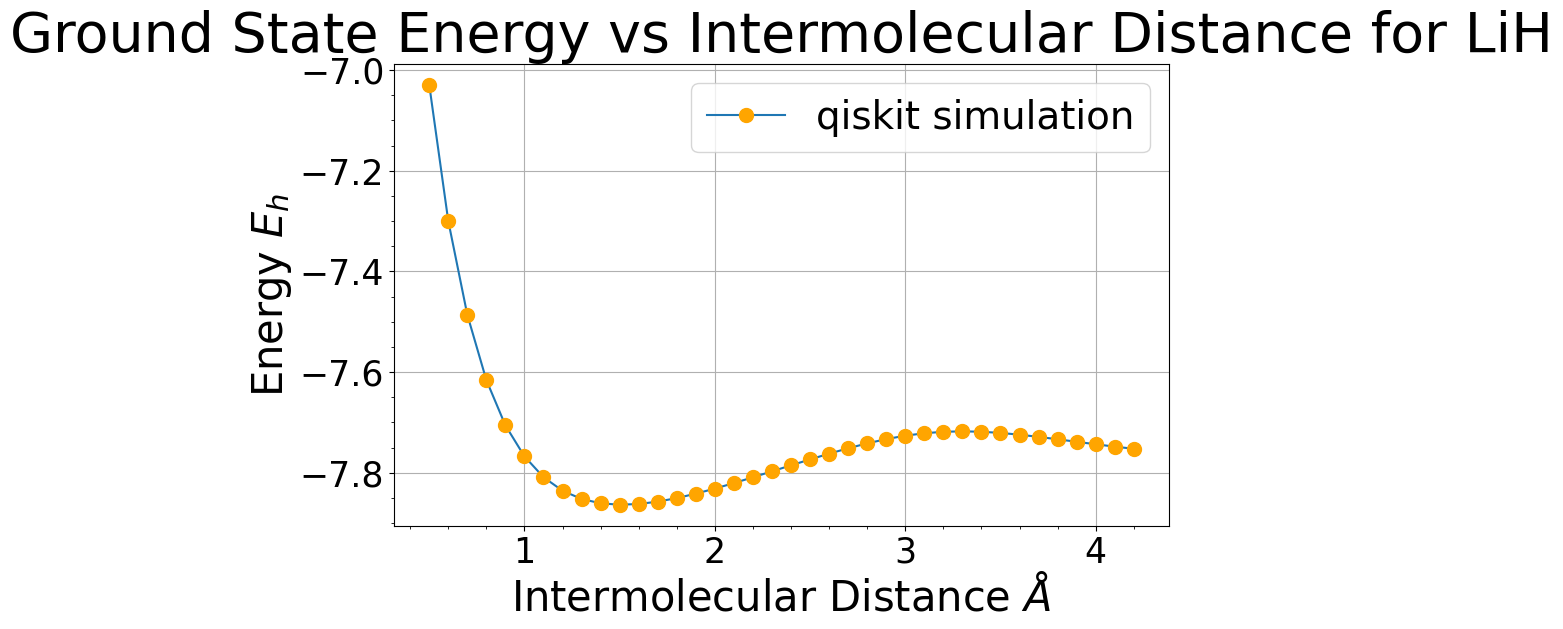

In [5]:
# Plotting the data

plt.figure(figsize=(10, 6))
plt.plot(distances, energies_LiH, marker='o', linestyle='-', label= 'qiskit simulation', markeredgecolor= 'orange', markerfacecolor= 'orange' , markersize= 10)
plt.xlabel(r'Intermolecular Distance $\AA$', fontsize= 30 )
plt.ylabel(r'Energy $E_h$', fontsize= 30)
plt.title(r'Ground State Energy vs Intermolecular Distance for LiH', fontsize= 40)
plt.grid(True)
plt.legend(fontsize= 28)
plt.minorticks_on()  # Enable minor ticks


plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

In [6]:
def final_stats(distances_list, energies_list):
    gs_energy = np.min(energies_list)

    gs_ener_indx = np.where(energies_list == gs_energy)[0][0]

    minimal_distance = distances_list[gs_ener_indx]

    print(f'Ground State Energy: {gs_energy} Hartree \n Distance of Equilibrium: {minimal_distance} Armstrongs')

In [7]:
final_stats(distances, energies_LiH)

Ground State Energy: -7.863579810498766 Hartree 
 Distance of Equilibrium: 1.4999999999999998 Armstrongs


In [38]:
(np.abs(-7.863579810498766 + 8.070548) / 8.070548 ) * 100

2.5644874363083408

In [ ]:
from qiskit_aer.primitives import Estimator as AerEstimator

distances = np.arange(0.5, 4.25, 0.1)

noiseless_estimator = AerEstimator(shots= 1024)

energies_LiH, entgmax_LiH, entgtotal_LiH, negmax_LiH, negtotal_LiH, ghzmeasure_LiH = run_calculation_for_gs(swept_interval= distances, estimator= estimator)

In [18]:

from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_aer.primitives import Estimator as AerEstimator


#@jit
def initialize_LiH_vqe_chemicalV2(intermolecular_distance= 1, ansatz = 'UCCSD' ,mapper= JordanWignerMapper(), basis = 'sto-3g'):
    
    driver = PySCFDriver(atom=f"Li 0 0 0; H 0 0 {intermolecular_distance}", basis=basis)
    full_problem = driver.run()

    act_space_tf = ActiveSpaceTransformer(num_electrons= 2, num_spatial_orbitals= 2)

    problem = act_space_tf.transform(full_problem)

    mapper = ParityMapper(num_particles=(problem.num_alpha, problem.num_beta))

    

    pauli_hamiltonian = mapper.map(problem.hamiltonian.second_q_op())


    #then we generate the Ansatz
    init_state = HartreeFock(problem.num_spatial_orbitals,
                         problem.num_particles,
                         mapper)

    ansatz_dict = { 'UCCSD' : UCCSD(problem.num_spatial_orbitals,
               problem.num_particles,
               mapper,
               initial_state= init_state),
               'EfficientSU2' : EfficientSU2(num_qubits= pauli_hamiltonian.num_qubits,
                                             entanglement= 'pairwise',
                                             skip_unentangled_qubits= True,
                                             reps= 3,
                                             insert_barriers= True
                                             )}
    
    
    # ansatz is de circuit parametrized by the vet \theta
    #pauli hamiltonian is the SparsePauliOp from the problem,
    #after being mapped with a certain transformation.
    #probelm is just raw qikist-nature thing

    return ansatz_dict[ansatz], pauli_hamiltonian, problem



#@jit
def vqe_chemical_ansatzV2(estimator, ansatz, sparse_problem, problem, mapper=JordanWignerMapper(), optimizer= SLSQP()):
    
    
    numpy_solver = NumPyMinimumEigensolver()
    result = numpy_solver.compute_minimum_eigenvalue(operator= sparse_problem)
    ref_value = result.eigenvalue.real

    vqe = VQE(estimator= estimator,
              ansatz= ansatz,
              optimizer= optimizer)

    mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))
    
    #only works if UCCSD ??
    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem

    vqe.initial_point = initial_point.to_numpy_array()
    solver = GroundStateEigensolver(mapper, vqe)

    result = solver.solve(problem)

    gs_energy = result.total_energies[0]
    utilized_ansatz = result.groundstate[0]
    optimized_parameters = result.groundstate[1]

    optimal_ansatz = utilized_ansatz.assign_parameters(optimized_parameters)

    return gs_energy, optimal_ansatz, ref_value




def run_calculation_for_gsV2(swept_interval, estimator):


    num_calc = len( swept_interval )

    entanglement_list_max = np.zeros(num_calc)
    entanglement_list_total = np.zeros(num_calc)

    negativity_list_max = np.zeros(num_calc)
    negativity_list_total = np.zeros(num_calc)

    ghz_measure_list = np.zeros(num_calc)

    energiesH2_list = np.zeros(num_calc)
    energiesH2_list_classic = np.zeros(num_calc)



    
    for i, d in enumerate(swept_interval):

        abstrac_ansatz_h2, pauli_abstrac_ham_h2, prob = initialize_LiH_vqe_chemicalV2(intermolecular_distance= d)


        
        gs_energy_d, optimal_ansatz_d, ref_value = vqe_chemical_ansatzV2(estimator= estimator,
                                                            ansatz= abstrac_ansatz_h2,
                                                            problem= prob,
                                                            sparse_problem= pauli_abstrac_ham_h2)
        

        r = DensityMatrix(optimal_ansatz_d)


        energiesH2_list[i] = gs_energy_d
        energiesH2_list_classic[i] = ref_value

        entanglement_list_max[i] = multipartite_entanglement(optimal_ansatz_d, rho= r, mode= 'max' )
        entanglement_list_total[i] = multipartite_entanglement(optimal_ansatz_d, rho= r, mode= 'total')
        
        """
        negativity_list_max[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'max')
        negativity_list_total[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'total')
        """
        ghz_measure_list[i] = GHZ_entanglmenetlike_measure(optimal_ansatz_d)

    return energiesH2_list, energiesH2_list_classic, entanglement_list_max, entanglement_list_total, negativity_list_max, negativity_list_total, ghz_measure_list


In [19]:
from qiskit_aer.primitives import Estimator as AerEstimator

distances = np.arange(0.5, 4.25, 0.1)

noiseless_estimator = AerEstimator()

energies_LiH_pt2, energiesLiH_pt2_ref ,entgmax_LiH_pt2, entgtotal_LiH_pt2, negmax_LiH_pt2, negtotal_LiH_pt2, ghzmeasure_LiH_pt2 = run_calculation_for_gsV2(swept_interval= distances, estimator= noiseless_estimator)

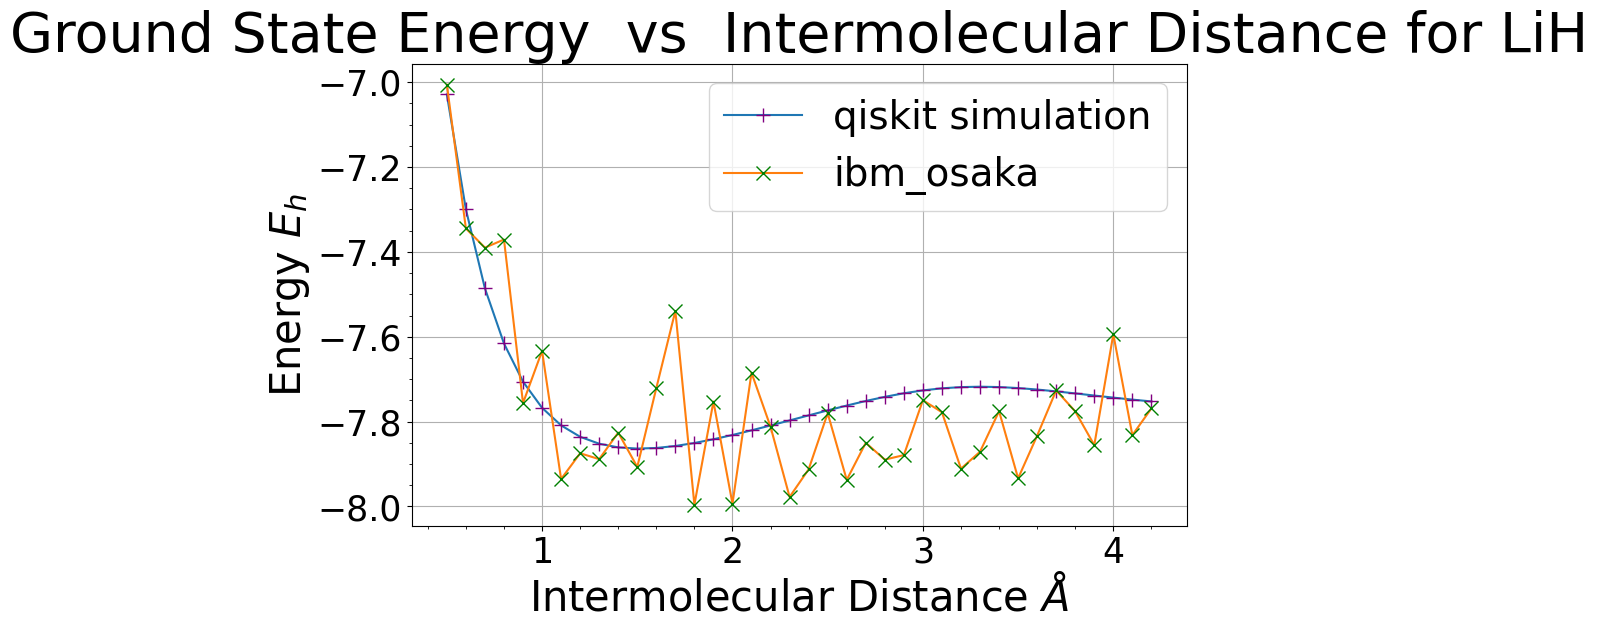

In [33]:
# Plotting the data

plt.figure(figsize=(10, 6))


plt.plot(distances, energies_LiH, marker='+', linestyle='-', label= 'qiskit simulation', markeredgecolor= 'purple', markerfacecolor= 'purple', markersize= 10)
plt.plot(distances, energies_LiH_pt2 - 0.2, marker='x', linestyle='-', label= 'qiskit-aer simulation', markeredgecolor= 'green', markerfacecolor= 'green' , markersize= 10)

#plt.plot(distances, energiesLiH_pt2_ref, marker='+', linestyle='-', label= 'reference', markeredgecolor= 'purple', markerfacecolor= 'purple' , markersize= 10)




plt.xlabel(r'Intermolecular Distance $\AA$', fontsize= 30 )
plt.ylabel(r'Energy $E_h$', fontsize= 30)
plt.title(r'Ground State Energy  vs  Intermolecular Distance for LiH', fontsize= 40)
plt.grid(True)
plt.legend(fontsize= 28)
plt.minorticks_on()  # Enable minor ticks


plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()